In [14]:
from langchain.chat_models import ChatOpenAI

llm = ChatOpenAI(
        base_url="http://localhost:8000/v1",
        api_key="not-needed",
        model_name="meta-llama/Llama-3.2-3B-Instruct",
        temperature=0.2,
        max_tokens=512
    )

# Document loading


In [ ]:
from pathlib import Path
from langchain.vectorstores import Qdrant
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.schema import Document

embedding_function = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")


# Load all .txt files into a list of documents
text_files = list(Path("./app/data/documents/").rglob("*.txt"))
documents = []
for file in text_files:
    text = file.read_text(encoding="utf-8")
    documents.append(Document(page_content=text, metadata={"source": str(file)}))

qdrant = Qdrant.from_documents(
    documents=documents,
    embedding=embedding_function,
    location="http://localhost:6333",  # adjust if needed
    collection_name="services_docs"
)

retriever = qdrant.as_retriever()

/home/gabri/anaconda3/envs/dcm_moguls/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [16]:
import logging
import os
from datetime import datetime

# Create a logger instance
logger = logging.getLogger("dcm_chatbot")
logging_level = logging.DEBUG
# Set log level (adjust as needed: DEBUG, INFO, WARNING, ERROR, CRITICAL)
logger.setLevel(logging.DEBUG)

# Create a custom formatter
formatter = logging.Formatter(
    fmt='%(asctime)s - %(levelname)s -%(name)s- %(funcName)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# Ensure directory exists
log_path = "./app/data/logs/"
os.makedirs(log_path, exist_ok=True)


log_filename = f"{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}_app.log"
file_path = os.path.join(log_path, log_filename)

# Create a file handler
file_handler = logging.FileHandler(file_path, mode='w', encoding='utf-8')
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

# Nodes


## Classification node

In [17]:
from langchain.prompts.example_selector import SemanticSimilarityExampleSelector
from langchain_community.vectorstores import Chroma
from langchain_huggingface import HuggingFaceEmbeddings
import pandas as pd
from typing import Dict, Any, Literal, Optional
from langchain.prompts import (
    ChatPromptTemplate, 
    SystemMessagePromptTemplate, 
    HumanMessagePromptTemplate, 
    FewShotPromptTemplate,
    PromptTemplate
    )

fs_class_examples = pd.read_csv("./app/data/few_shot_examples/classification.csv").to_dict(orient="records")

# Create chroma for few shot examples for msg classification.
db_class = Chroma(collection_name="msg_class_examples", embedding_function=embedding_function)
db_class.add_texts([e["input"] for e in fs_class_examples], metadatas=fs_class_examples)

# Few shot example selector for shopping message classification.
class_example_selector = SemanticSimilarityExampleSelector(
    vectorstore=db_class,
    k=5
)

class_prompt = """You are a helpful assistant for a marketing agency chatbot.

Your task is to classify incoming user messages into one of the following intent categories:

- greeting: Simple greetings like "hi", "hello", "good morning".
- faq: Questions about pricing, results, timelines, or guarantees.
- services: User expresses interest in growing their business, marketing services, or customer acquisition.
- contact_info: The user provides their name, email address, or phone number.
- unknown: The message doesn’t match any known category (e.g., emojis, unrelated content).

Use only one intent per message. If the message includes multiple things, choose the one that reflects the **primary purpose** of the message.


Below are examples of messages and their intent class.

"""

suffix_class = """Classify the following message:

Message: {input}
Intent:
"""
# Few shot prompt for message classification.
fs_prompt_msg_class = FewShotPromptTemplate(
    example_selector=class_example_selector,
    example_prompt=PromptTemplate(
        input_variables=["input", "class"],
        template="Message: {input}\n{class}"
    ),
    prefix=class_prompt,
    suffix=suffix_class,
    input_variables=["input"]
)

def classification_node(state:Dict[str, Any], config)->Dict[str, Any]:
    """
    Classifies the input text into categories.
    """
    llm = config['configurable']['llm']
    llm_prompt = fs_prompt_msg_class.format(input=state['messages'][-1].content)
    logger.debug(f'LLM prompt:\n{llm_prompt}')
    llm_response = llm.invoke(llm_prompt)
    llm_response_text = llm_response.content.strip().lower()
    logger.info(f'Model response:\n{llm_response_text}')
    if 'greeting_or_profession' in llm_response_text:
        msg_type = "greeting_or_profession"
    elif 'services' in llm_response_text:
        msg_type = "services"
    elif 'contact_info' in llm_response_text:
        msg_type = "contact_info"
    elif 'faq' in llm_response_text:
        msg_type = "faq"
    elif 'generic_greeting' in llm_response_text:
        msg_type = "generic_greeting"
    else:
        msg_type = "unknown"
    return {'msg_type': msg_type}

/home/gabri/anaconda3/envs/dcm_moguls/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


## Entity recognition nodes

In [18]:

import json

def load_few_shot_examples(file_path: str) -> list:
    examples = []
    with open(file_path, encoding='utf-8') as f:
        for line in f:
            row = json.loads(line)
            # Escapamos llaves del output para LangChain.format()
            output_str = json.dumps(row["entities"], ensure_ascii=False)
            escaped_output = output_str.replace("{", "{{").replace("}", "}}")
            examples.append({
                "input": row["input"].strip(),
                "entities": escaped_output
            })
        return examples

fs_entity_examples = load_few_shot_examples("./app/data/few_shot_examples/entity_recognition.jsonl")
try:
    db_entity.delete_collection()
except NameError as e:
    pass
db_entity = Chroma(collection_name="entity_recognition_examples", embedding_function=embedding_function)
db_entity.add_texts(
    [e["input"] for e in fs_entity_examples],
    metadatas=fs_entity_examples
)

entity_example_selector = SemanticSimilarityExampleSelector(
    vectorstore=db_entity,
    k=5
)
class_prompt = """You are an assistant that extracts entities from user messages related to marketing clients.

Extract the following entities when present:

- name: person’s full name
- profession: job title or profession
- email: email address
- phone: phone number (digits, with or without separators)

Format your output as a JSON object with keys for found entities.
If an entity is not present in the message, do not include that key in the output.

Examples:

"""

suffix_class = """Extract entities from the following message. Do not include any additional text or explanation.

Message: {input}
Entities:
"""
# Few shot prompt for message classification.
fs_prompt_entities = FewShotPromptTemplate(
    example_selector=entity_example_selector,
    example_prompt=PromptTemplate(
        input_variables=["input", "entities"],
        template="Message: {input}\nEntities: {entities}"
    ),
    prefix=class_prompt,
    suffix=suffix_class,
    input_variables=["input"]
)

def entity_recognition_node(state:Dict[str, Any], config)->Dict[str, Any]:
    """
    Extracts entities from the input text.
    """
    logger.debug(f"State before entity recognition: {state}")
    llm = config['configurable']['llm']

    llm_prompt = fs_prompt_entities.format(input=state['messages'][-1].content)
    logger.info(f'LLM prompt:\n{llm_prompt}')
    llm_response = llm.invoke(llm_prompt)
    logger.info(f'Model response:\n{llm_response.content}')
    try:
        detected_entities = eval(llm_response.content)
        logger.debug(f'Parsed entities: {detected_entities}')
        entities = {}
        if isinstance(detected_entities, dict):
            for key, value in detected_entities.items():
                if key == "name":
                    entities['customer_name'] = value.strip()
                elif key == "profession":
                    if value.strip().lower() not in ["", "unknown", "null", "none"]:
                        entities['customer_profession'] = value.strip()
                    else: 
                        entities['customer_profession'] = None
                elif key == "email":
                    entities['customer_email'] = value.strip()
            return {**entities}
        else:
            logger.error(f'Invalid response format: {llm_response.content}')
            return {**state}
    except Exception as e:
        logger.error(f'Error parsing response: {e}')
        return {**state}

In [19]:
# Test query input
query = "Hi, I'm Gabriel, a dentist. Can you tell me about your services? "

# Get selected examples
examples = entity_example_selector.select_examples({"input": query})

# Print selected examples
print("Selected examples for query: ", query)
for i, ex in enumerate(examples, 1):
    print(f"Example #{i}")
    print("Input:", ex["input"])
    print("Entities:", ex["entities"])
    print("---")

Selected examples for query:  Hi, I'm Gabriel, a dentist. Can you tell me about your services? 
Example #1
Input: I’m a dentist looking to grow my practice.
Entities: [{{"profession": "dentist"}}]
---
Example #2
Input: I’m a dentist by profession.
Entities: [{{"profession": "dentist"}}]
---
Example #3
Input: This is Lisa, my email is lisa.dentist@example.org.
Entities: [{{"name": "Lisa", "email": "lisa.dentist@example.org"}}]
---
Example #4
Input: Contact: Sarah, dentist, sarah.dental@gmail.com, phone 5554442211.
Entities: [{{"name": "Sarah", "profession": "dentist", "email": "sarah.dental@gmail.com", "phone": "5554442211"}}]
---
Example #5
Input: Contact info: sarah.dentist@example.com and phone 321-123-4567.
Entities: [{{"email": "sarah.dentist@example.com", "phone": "321-123-4567"}}]
---


## Greetings node

In [20]:
greetings_prompt = """
You are a helpful marketing assistant chatbot. The current time is {time_str}.

Greet the user warmly, adapting your greeting to the time of day:
- Morning (05:00-11:59): Use greetings like 'Good morning'
- Afternoon (12:00-17:59): Use greetings like 'Good afternoon'
- Evening (18:00-21:59): Use greetings like 'Good evening'
- Night (22:00-04:59): Use polite neutral greetings like 'Hello'

If the user's latest message contains their name or any other personal details, incorporate that naturally into your greeting to make it more personal. However, only use the name if it is explicitly and clearly stated by the user; do not guess or assume any names.

After greeting, kindly ask the user what their profession is, choosing from:
small business owner, lawyer, dentist, or contractor.

Then ask for their contact information (name, email, and phone number), so you can help them better.

Keep the tone professional, friendly, and conversational.
"""


greetings_template = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template(greetings_prompt),
    HumanMessagePromptTemplate.from_template("{input}")
])

def greetings_node(state: Dict[str, Any], config)->Dict[str, Any]:
    llm = config['configurable']['llm']
    time_str = datetime.now().strftime("%H:%M:%S")
    messages = greetings_template.format_messages(input=state['messages'][-1], time_str=time_str)
    response = llm.invoke(messages)
    updated_messages = state['messages'] + [response]
    return {**state, "output": response.content, 'messages':updated_messages}

## Contact info node

In [21]:
import requests

def submit_google_form(name: str, email: str, profession: str) -> None:
    """
    Submits a Google Form with predefined data.
    """
    FORM_ULR = "https://docs.google.com/forms/d/e/1FAIpQLSc2XWE-yvyQJj8s4Kh8OYvIVBFhrrU2z-vjEwcJiFno3cK8ow/formResponse"

    form_data = {
        "entry.1554944402": name,        # name
        "entry.662612736": email,  # email
        "entry.1844920426": profession[0].upper()+profession[1:]         # profession (must match dropdown option)
    }
    headers = {
    "Content-Type": "application/x-www-form-urlencoded"
}
    
    logger.debug(f"Submitting form with data: {form_data}")
    
    # Send the POST request
    response = requests.post(FORM_ULR, data=form_data, headers=headers)

    # Optional: Check if it worked
    if response.status_code == 200:
        logger.debug("Form submitted successfully.")
    else:
        logger.debug(f"Form submission failed. Status code: {response.status_code}")
        

# Node function
def contact_info_node(state: Dict[str, Any], config) -> Dict[str, Any]:
    llm = config["configurable"]["llm"]
    input_msg = state["messages"][-1]  # Most recent user message

    # Extract current known values from state
    name = state.get("customer_name")
    profession = state.get("customer_profession")
    email = state.get("customer_email")

    # Build custom summary of known and missing fields
    known = []
    missing = []

    if name:
        known.append(f"name: {name}")
    else:
        missing.append("name")
    if profession:
        known.append(f"profession: {profession}")
    else:
        missing.append("profession")
    if email:
        known.append(f"email: {email}")
    else:
        missing.append("email")

    # Compose synthetic user input to instruct LLM
    summary = ""
    if len(known) == 3:
        summary += f"We already have all your contact information. An agent will reach out as soon as possible.\n"
        submit_google_form(name=name, email=email, profession=profession)
    elif known:
        summary += f"I already have your {' and '.join([f.split(':')[0] for f in known])}.\n"
    if missing:
        summary += f"Could you please share your {' and '.join(missing)}?"


    # Update message history
    updated_messages = state["messages"] + [AIMessage(content= summary)]

    return {
        "messages": updated_messages
    }

## RAG 

In [22]:
# Prompt to answer based on context
context_prompt = PromptTemplate.from_template("""
You are a helpful assistant for a marketing company. Use the context below to answer the user's question.

Context:
{context}

Question:
{question}

If the answer is not in the context, say you are unsure and will forward the question to a human.
""")

def retrieve_and_respond_node(state: Dict[str, Any], config: Dict[str, Any]) -> Dict[str, Any]:
    retriever = config["configurable"]["retriever"]
    llm = config["configurable"]["llm"]

    query = state["messages"][-1].content

    # 1. Retrieve documents
    docs = retriever.get_relevant_documents(query)
    retrieved_text = "\n\n".join(doc.page_content for doc in docs)

    logger.info(f"Retrieved {len(docs)} documents for query: {query}")
    logger.debug(f"Retrieved text: {retrieved_text}...") 
    # 2. Format the prompt
    prompt = context_prompt.format(context=retrieved_text, question=query)

    # 3. Generate the answer
    response = llm.invoke(prompt)

    # 4. Update the state
    updated_messages = state["messages"] + [response]

    return {
        "messages": updated_messages
    }

# Graph definiton

In [23]:
from langgraph.graph import StateGraph, MessagesState, END 
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage, AIMessage

# --- Define the State ---
class AppState(MessagesState):
    msg_type: Literal["services", "contact_info", "faq", "generic_greeting", "unknown"]
    customer_phone_number: str | None = None
    customer_name: str | None = None
    customer_profession: Optional[Literal["services", "contact_info", "faq", "generic_greeting"]] = None
    customer_email: str | None = None

# --- Build the LangGraph ---
graph = StateGraph(AppState)

graph.add_node("classification_node", classification_node)
graph.add_node("entity_recognition_node", entity_recognition_node)
graph.add_node("greetings_node", greetings_node)
graph.add_node("contact_info_node", contact_info_node)
graph.add_node("services_node", retrieve_and_respond_node)


fallback_message = lambda state: {state['messages'] + [AIMessage(
    content="I'm not sure how to help with that. Let me connect you with a human agent.")]}

def fallback_node(state: Dict[str, Any], config: Dict[str, Any]) -> Dict[str, Any]:
    """
    Fallback node that handles unknown messages.
    """
    response = AIMessage(
        content="I'm only able to provide you with information about our services and frequently asked questions. I am unable to answer unrelated questions. If you need help with something else, please contact our support team."
    )
    updated_messages = state['messages'] + [response]
    return {**state, "output": response.content, 'messages': updated_messages}

graph.add_node("fallback_node", fallback_node)


# Set entry point
graph.set_entry_point("classification_node")

graph.add_edge("classification_node", "entity_recognition_node")
graph.add_edge("greetings_node", END)
graph.add_edge("services_node", END)
graph.add_edge("contact_info_node", END)

def routing_function(state: AppState) -> str:
    """
    Routes the state to the appropriate node based on the message type.
    """
    if state['msg_type'] == "greeting_or_profession" or state['msg_type'] == "generic_greeting":
        return "greetings"
    elif state['msg_type'] == "contact_info":
        return "contact_info"
    elif state['msg_type'] == "services":
        if state['customer_profession'] in [None, "unknown"]:
            return "contact_info"
        else:
            return "services"
    else:
        return "unknown"
    
graph.add_conditional_edges("entity_recognition_node", routing_function, {
    "greetings": "greetings_node",
    "services": "services_node",
    "contact_info": "contact_info_node",
    "unknown": "fallback_node"
})



# Stored in RAM so it forgets whenever process is stopped.
memory = MemorySaver()

# Compile graph
compiled_graph = graph.compile(checkpointer=memory)

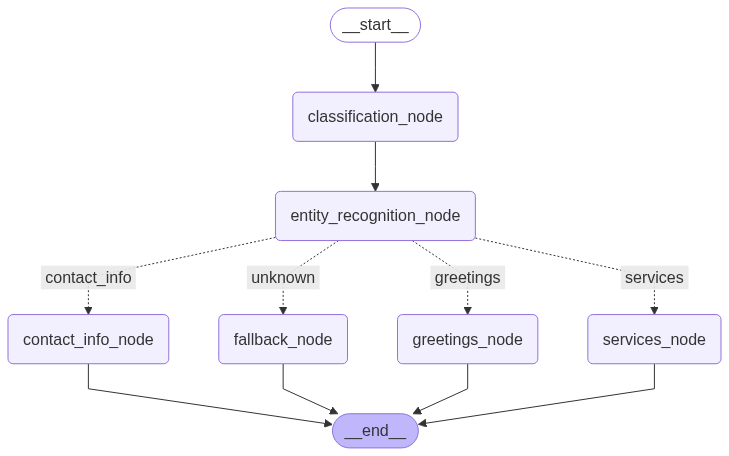

In [24]:
from IPython.display import Image, display

display(Image(compiled_graph.get_graph().draw_mermaid_png()))

In [25]:
import uuid
thread_id = str(uuid.uuid4())# Generate a unique thread ID for this conversation
config = {
    "configurable": {
        "thread_id": thread_id,
        "llm": llm,
        "retriever": retriever
        }
}
state = {"messages": [HumanMessage("Hello, my name is Gabriel. I am a dentist and want to know about your services.")]}
response = compiled_graph.invoke(
    input=state, config=config)
response

/home/gabri/anaconda3/envs/dcm_moguls/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/home/gabri/anaconda3/envs/dcm_moguls/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/home/gabri/anaconda3/envs/dcm_moguls/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


{'messages': [HumanMessage(content='Hello, my name is Gabriel. I am a dentist and want to know about your services.', additional_kwargs={}, response_metadata={}, id='0b48f2fc-107a-479c-99c3-6ea4e0c5382a'),
  AIMessage(content="Hello Gabriel, I'm happy to help. We specialize in SEO for dentists, and our team has helped hundreds of dental offices expand their practice by putting their brand in front of their target audience. We don't use cookie-cutter strategies that simply follow best practices. Instead, our approaches are tailored specifically to the dental industry and your practice. Can you tell me a bit more about what you're looking to achieve with your SEO efforts?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 89, 'prompt_tokens': 413, 'total_tokens': 502, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'meta-llama/Llama-3.2-3B-Instruct', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='r

In [26]:
thread_id = str(uuid.uuid4())# Generate a unique thread ID for this conversation
config = {
    "configurable": {
        "thread_id": thread_id,
        "llm": llm,
        "retriever": retriever
        }
}
state = {"messages": [HumanMessage("Hello, could you tell me about your services?")]}
response = compiled_graph.invoke(
    input=state, config=config)

response

/home/gabri/anaconda3/envs/dcm_moguls/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/home/gabri/anaconda3/envs/dcm_moguls/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


{'messages': [HumanMessage(content='Hello, could you tell me about your services?', additional_kwargs={}, response_metadata={}, id='555cdac7-d817-4338-a0e2-33834009e053'),
  AIMessage(content='Could you please share your name and profession and email?', additional_kwargs={}, response_metadata={}, id='1b834604-7050-4d77-99ad-0de20a7b44ff')],
 'msg_type': 'services',
 'customer_profession': None}

In [27]:
thread_id = str(uuid.uuid4())# Generate a unique thread ID for this conversation
config = {
    "configurable": {
        "thread_id": thread_id,
        "llm": llm,
        "retriever": retriever
        }
}
state = {"messages": [HumanMessage("Hello, could you tell me about your services?")]}
response = compiled_graph.invoke(
    input=state, config=config)

response

/home/gabri/anaconda3/envs/dcm_moguls/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/home/gabri/anaconda3/envs/dcm_moguls/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


{'messages': [HumanMessage(content='Hello, could you tell me about your services?', additional_kwargs={}, response_metadata={}, id='2520fa53-9332-4748-8c32-098d710e050f'),
  AIMessage(content='Could you please share your name and profession and email?', additional_kwargs={}, response_metadata={}, id='b038897a-916a-4a8a-a977-0ffda09a6868')],
 'msg_type': 'services',
 'customer_profession': None}

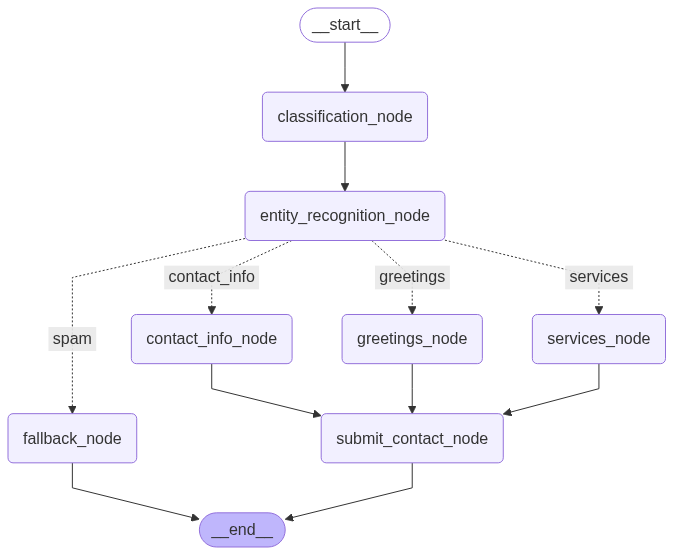

In [4]:
from langgraph.graph import StateGraph, MessagesState, END 
from langgraph.checkpoint.memory import MemorySaver
from typing import Literal, Optional

from app.core.logger import logger
from app.services.nodes.classification_node import classification_node
from app.services.nodes.entity_recognition_node import entity_recognition_node
from app.services.nodes.greetings_node import greetings_node
from app.services.nodes.contact_info_node import contact_info_node
from app.services.nodes.services_node import retrieve_and_respond_node
from app.services.nodes.fallback_node import fallback_node
from app.services.nodes.submit_form_node import submit_contact_node

def build_chatbot_graph():

    # --- Define the State ---
    class AppState(MessagesState):
        msg_type: Literal["services", "contact_info", "generic_greeting", "spam"]
        customer_phone_number: Optional[str] = None
        customer_name: Optional[str] = None
        customer_profession: Optional[Literal["business owner", "contractor", "dentist", "lawyer"]] = None
        customer_email: Optional[str] = None
        form_submitted: bool = False

    # --- Build the LangGraph ---
    graph = StateGraph(AppState)

    graph.add_node("classification_node", classification_node)
    graph.add_node("entity_recognition_node", entity_recognition_node)
    graph.add_node("greetings_node", greetings_node)
    graph.add_node("contact_info_node", contact_info_node)
    graph.add_node("services_node", retrieve_and_respond_node)
    graph.add_node("submit_contact_node", submit_contact_node)


   

    graph.add_node("fallback_node", fallback_node)


    # Set entry point
    graph.set_entry_point("classification_node")

    graph.add_edge("classification_node", "entity_recognition_node")
    graph.add_edge("greetings_node", "submit_contact_node")
    graph.add_edge("services_node", "submit_contact_node")
    graph.add_edge("contact_info_node", "submit_contact_node")
    graph.add_edge("submit_contact_node", END)

    def routing_function(state: AppState) -> str:
        """
        Routes the state to the appropriate node based on the message type.
        """
        logger.debug(f"State before routing: {state}")
        return_flag = None
        if state['msg_type'] == "generic_greeting":
            return_flag = "greetings"
        elif state['msg_type'] == "contact_info":
            return_flag = "contact_info"
        elif state['msg_type'] == "services":
            if state['customer_profession'] is None:
                return_flag = "contact_info"
            else:
                return_flag = "services"
        else:
            return_flag = "spam"
        logger.debug(f"Routing based on msg_type: {state['msg_type']} to {return_flag}")
        return return_flag
    
    
    graph.add_conditional_edges("entity_recognition_node", routing_function, {
        "greetings": "greetings_node",
        "services": "services_node",
        "contact_info": "contact_info_node",
        "spam": "fallback_node"
    })



    # Stored in RAM so it forgets whenever process is stopped.
    memory = MemorySaver()

    # Compile graph
    return graph.compile(checkpointer=memory)

compiled_graph = build_chatbot_graph()
from IPython.display import Image, display

display(Image(compiled_graph.get_graph().draw_mermaid_png()))

ValueError: Found edge ending at unknown node `<function submit_contact_node at 0x7be15ca76520>`